**Gene devided in four group**
1. genes are not acted by eRNA
2. genes are targeted by at least one eRNA, but there isn't Alu element in the eRNA sequence
3. genes are targeted by at least one eRNA, and the polyA length for the Alu in these eRNA is relatively short
4. genes are targeted by at least one eRNA, and the polyA length for the Alu in these eRNA is relatively long

In [399]:
import pandas as pd
import re
from collections import defaultdict as ddict
import os
import subprocess
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pyBigWig

In [400]:
df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)

In [401]:
# get the information of longest Alu polyA for each eRNA. Mark as -1 if no Alu in the eRNA
cmd = f"bedtools intersect -a eRNA_hommer.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e -s > eRNA_Alu_intersectWo.txt"
subprocess.run(cmd, shell=True)
eRNA_Alu_intersectWo_df = pd.read_csv('eRNA_Alu_intersectWo.txt', sep='\t', header=None)
eRNA_Alu_polyAlength_dict = eRNA_Alu_intersectWo_df.groupby(3).agg({20: 'max'}).to_dict()[20]
df['eRNA_name'] = df[6].str.split(';').str[0]
df['gene_name'] = df[6].str.split(';').str[1]
df['eRNA_Alu_polyA_length'] = df['eRNA_name'].map(eRNA_Alu_polyAlength_dict)
df = df.fillna(-1)

In [402]:
# Align the encodeID with geneName
expression_df = pd.read_csv('ENCFF239AZD.tsv', delim_whitespace=True)

encID_gene_dict = ddict(str)
with open('gencode.v19.annotation.gtf', 'r') as infile:
    for line in infile:
        if line.startswith('#'):
            continue
        gene_ID = re.search(r'gene_id "(\S*)"', line).group(1)
        gene_name = re.search(r'gene_name "(\S*)"', line).group(1)
        encID_gene_dict[gene_ID] = gene_name

expression_df['gene_name'] = expression_df['gene_id'].map(encID_gene_dict)

# retain only the protein coding gene
expression_filter_df = expression_df[expression_df['gene_name']!='']

In [418]:
# Align the gene with its TPM. If more than one transcripts of one gene, we sum the TPM.
geneName_TPM_sum_dict = dict(zip(
    expression_filter_df.groupby('gene_name').agg({'TPM':'sum'}).reset_index()['gene_name'],
    expression_filter_df.groupby('gene_name').agg({'TPM':'sum'}).reset_index()['TPM']
))

geneName_TPM_mean_dict = dict(zip(
    expression_filter_df.groupby('gene_name').agg({'TPM':'mean'}).reset_index()['gene_name'],
    expression_filter_df.groupby('gene_name').agg({'TPM':'mean'}).reset_index()['TPM']
))

promoter_df = pd.read_csv('promoter.bed', sep='\t', header=None)
promoter_df['expression'] = promoter_df[3].map(geneName_TPM_sum_dict)
gene_exp_df = promoter_df[[3, 'expression']]
gene_exp_df.columns = ['gene_name', 'expression']
epi_polyA_gene_exp_df = pd.merge(df, gene_exp_df, on = ['gene_name'], how='outer')

In [404]:
gene_filter_threshold = 0
splitRatio_i = 0.5

In [405]:
# Gene expression of Group 1
non_eRNA_target_gene_set = set(epi_polyA_gene_exp_df[epi_polyA_gene_exp_df['eRNA_name'].isna()]['gene_name'].drop_duplicates().to_list())
non_eRNA_target_gene_filter_set = set(epi_polyA_gene_exp_df[(epi_polyA_gene_exp_df['eRNA_name'].isna()) &  (epi_polyA_gene_exp_df['expression']>gene_filter_threshold)]['gene_name'].drop_duplicates().to_list())
non_eRNA_target_gene_expression = epi_polyA_gene_exp_df[epi_polyA_gene_exp_df['gene_name'].isin(non_eRNA_target_gene_set)].groupby('gene_name').agg({'expression':'mean'}).dropna().values.squeeze()
non_eRNA_target_gene_expression_filter = non_eRNA_target_gene_expression[non_eRNA_target_gene_expression>gene_filter_threshold]

# Gene expression of Group 2
target_by_eRNA_df = epi_polyA_gene_exp_df[~epi_polyA_gene_exp_df['eRNA_name'].isna()]
gene_target_by_polyA_set = set(target_by_eRNA_df[target_by_eRNA_df['eRNA_Alu_polyA_length']>-1]['gene_name'].to_list())
nonAlu_target_gene_df = target_by_eRNA_df[~target_by_eRNA_df['gene_name'].isin(gene_target_by_polyA_set)]
nonAlu_eRNA_target_gene_set = set(nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'}).index.to_list())
nonAlu_eRNA_target_gene_filter_set = set(nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})[nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})['expression'] > gene_filter_threshold].index.to_list())
nonAlu_eRNA_target_gene_expression = nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})['expression'].values
nonAlu_eRNA_target_gene_expression_filter = nonAlu_eRNA_target_gene_expression[nonAlu_eRNA_target_gene_expression > gene_filter_threshold]

# Gene expression of Group 3
Alu_target_gene_df = target_by_eRNA_df[~target_by_eRNA_df['gene_name'].isin(nonAlu_eRNA_target_gene_set)]
Alu_target_gene_df = Alu_target_gene_df.replace(-1, 0)
Alu_target_gene_df = Alu_target_gene_df.groupby('gene_name').agg({'expression':'mean', 'eRNA_Alu_polyA_length':'sum'})
splitRatio = Alu_target_gene_df['eRNA_Alu_polyA_length'].quantile(splitRatio_i)
# splitRatio = Alu_target_gene_df['eRNA_Alu_polyA_length'].mean()
longPolyA_Alu_eRNA_target_gene_expression = Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] >= splitRatio]['expression'].values
longPolyA_Alu_eRNA_target_gene_set = set(Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] >= splitRatio].index.to_list())
longPolyA_Alu_eRNA_target_gene_expression_filter = longPolyA_Alu_eRNA_target_gene_expression[longPolyA_Alu_eRNA_target_gene_expression>gene_filter_threshold]
longPolyA_Alu_eRNA_target_gene_filter_set = set(Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] >= splitRatio][Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] >= splitRatio]['expression']>0].index.to_list())

# Gene expression of Group 4
shortPolyA_Alu_eRNA_target_gene_expression = Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] < splitRatio]['expression'].values
shortPolyA_Alu_eRNA_target_gene_set = set(Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] < splitRatio].index.to_list())
shortPolyA_Alu_eRNA_target_gene_expression_filter = shortPolyA_Alu_eRNA_target_gene_expression[shortPolyA_Alu_eRNA_target_gene_expression>gene_filter_threshold]
shortPolyA_Alu_eRNA_target_gene_filter_set = set(Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] < splitRatio][Alu_target_gene_df[Alu_target_gene_df['eRNA_Alu_polyA_length'] < splitRatio]['expression']>0].index.to_list())

In [406]:
# Used in ecdfplot. To keep the range of x_axis
def dealLarger200TPM(c, max_num=50, begin_ratio=0.1):
    larger200Num = c[c>max_num*(1-begin_ratio)].shape[0]
    if larger200Num > 0:
        max_num = max_num
        add_num = max_num*begin_ratio / larger200Num
        c_list = list()
        for i in c:
            if i > max_num*(1-begin_ratio):
                c_list.append(max_num*(1-begin_ratio)+add_num)
                add_num += max_num*begin_ratio / larger200Num
            else:
                c_list.append(i)
        return(np.array(c_list))
    else:
        return(c)

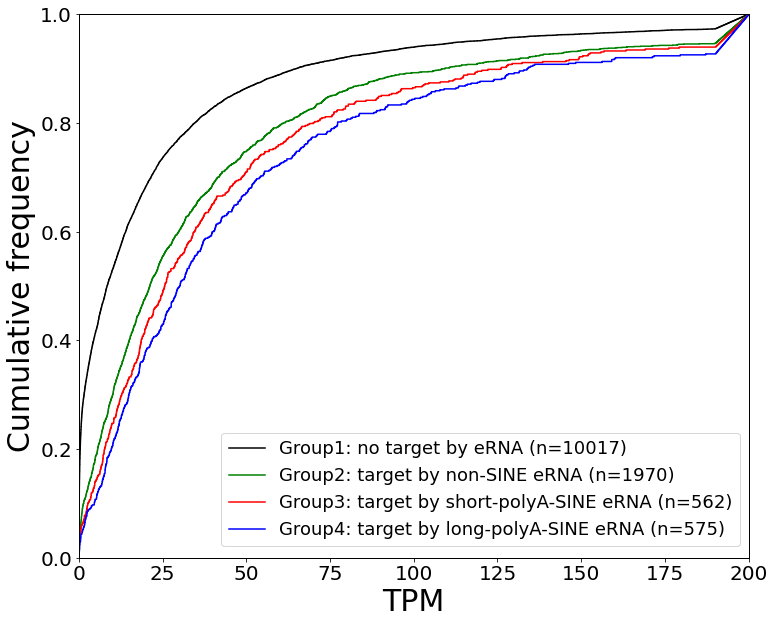

In [407]:
# Plot
fig, ax = plt.subplots(figsize=(12, 10))
plt.rc('axes', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('TPM', fontsize=30)
ax.set_ylabel('Cumulative frequency', fontsize=30)

max_num = 200
begin_ratio = 0.05

dealLargerTPM_non_eRNA_target_gene_expression = dealLarger200TPM(non_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_non_eRNA_target_gene_expression, color='black', ax=ax)
dealLargerTPM_nonAlu_eRNA_target_gene_expression = dealLarger200TPM(nonAlu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_nonAlu_eRNA_target_gene_expression, color='green', ax=ax)
dealLargerTPM_shortPolyA_Alu_eRNA_target_gene_expression = dealLarger200TPM(shortPolyA_Alu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_shortPolyA_Alu_eRNA_target_gene_expression, color='red', ax=ax)
dealLargerTPM_longPolyA_Alu_eRNA_target_gene_expression = dealLarger200TPM(longPolyA_Alu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_longPolyA_Alu_eRNA_target_gene_expression, color='blue', ax=ax)

fig.legend(
    labels=[f'Group1: no target by eRNA (n={non_eRNA_target_gene_expression_filter.shape[0]})',
            f'Group2: target by non-SINE eRNA (n={nonAlu_eRNA_target_gene_expression_filter.shape[0]})',
            f'Group3: target by short-polyA-SINE eRNA (n={shortPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})',
            f'Group4: target by long-polyA-SINE eRNA (n={longPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})', 
           ],  
    loc="right", fontsize=18, bbox_to_anchor=(0.9,0.22)
    )
ax.set_xlim(gene_filter_threshold, max_num)
# ax.set_xlim(10, max_num)
# ax.set_ylim(0.2, 1)
plt.savefig('geneExpression.svg', format='svg', dpi=300)

In [408]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, shortPolyA_Alu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, shortPolyA_Alu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=1.099537152992202, pvalue=0.13588349998655094)
MannwhitneyuResult(statistic=172305.5, pvalue=0.026294341231453734)


In [409]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=1.781872200125561, pvalue=0.03744468569403154)
MannwhitneyuResult(statistic=649070.0, pvalue=4.79774218199983e-08)


In [410]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, non_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, non_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=6.207066926215622, pvalue=2.800178852305858e-10)
MannwhitneyuResult(statistic=4130931.5, pvalue=3.2374525306099964e-69)


In [411]:
print(stats.ttest_ind(shortPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(shortPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=0.2016369407748406, pvalue=0.42010838695619546)
MannwhitneyuResult(statistic=598926.5, pvalue=0.0015039696455585489)


In [419]:
promoter_df['kind'] = promoter_df.apply(lambda x:'1' if x[3] in non_eRNA_target_gene_filter_set else '2' if  x[3] in nonAlu_eRNA_target_gene_filter_set else '4' if x[3] in longPolyA_Alu_eRNA_target_gene_set else '3' if x[3] in shortPolyA_Alu_eRNA_target_gene_set else '5', axis=1)

In [420]:
promoter_df = promoter_df.loc[promoter_df['kind']!='5']

In [416]:
atacBW = pyBigWig.open('ENCFF901GZH.bigWig')
def ifRetain(row):
    chr = row[0]
    start = row[1]
    end = row[2]
    atacScore = np.array(atacBW.stats(chr, start, end, type='mean', nBins=1))[0]
    return atacScore

In [436]:
promoter_df['atacScore'] = promoter_df.apply(ifRetain, axis=1)
a = promoter_df[promoter_df['kind']=='3']['atacScore']
b = promoter_df[promoter_df['kind']=='4']['atacScore']

/tmp/ipykernel_3095594/479896818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_df['atacScore'] = promoter_df.apply(ifRetain, axis=1)


In [439]:
print(stats.mannwhitneyu(a, b, alternative='less'))
stats.ttest_ind(a, b, alternative='less')

MannwhitneyuResult(statistic=204243.0, pvalue=0.35484241683391265)


Ttest_indResult(statistic=-0.6053450217464108, pvalue=0.27252837354457576)

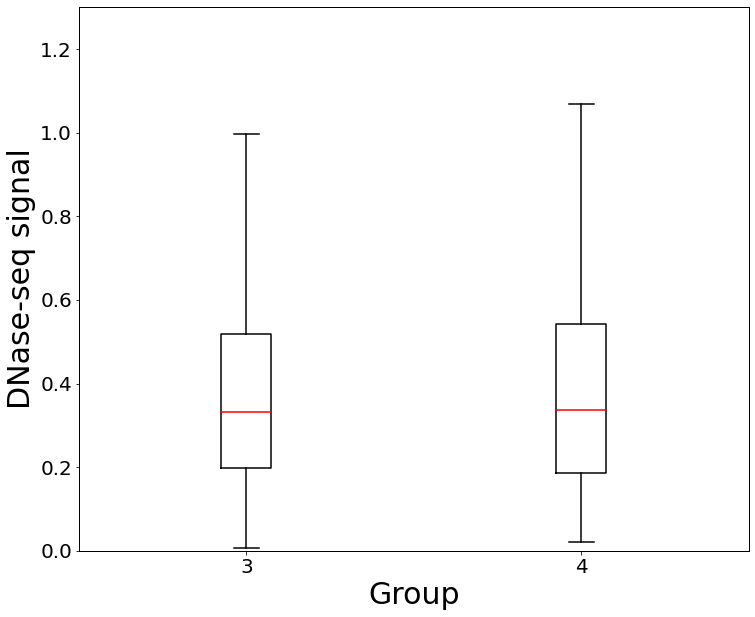

In [435]:
promoter_df = promoter_df.loc[promoter_df['kind'].isin({'3', '4'})]
grouped_df = promoter_df.groupby('kind')

data = []
for name, group in grouped_df:
    data.append(np.log(group['atacScore']+1))
    
fig, ax = plt.subplots(figsize=(12, 10))
plt.rc('axes', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Group', fontsize=30)
ax.set_ylabel('DNase-seq signal', fontsize=30)
ax.set_ylim(0, 1.3)
# ax.set_yticks([])
plt.boxplot(data, labels=grouped_df.groups.keys(), showfliers=False,
            medianprops=dict(color='red', linewidth=1.5), 
            boxprops={'linewidth': 1.5},
            whiskerprops={'linewidth': 1.5},
           capprops={'linewidth': 1.5})
plt.savefig('geneAccessibility.svg', format='svg', dpi=300)

# Try2

In [521]:
import pandas as pd
import re
from collections import defaultdict as ddict
import os
import subprocess
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pyBigWig

In [522]:
df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)

In [523]:
# get the information of longest B1/B2 polyA for each eRNA. Mark as -1 if no B1/B2 in the eRNA
cmd = f"bedtools intersect -a eRNA_hommer.bed -b hg19.SINE.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e -s > eRNA_SINE_intersectWo.txt"
subprocess.run(cmd, shell=True)
eRNA_Alu_intersectWo_df = pd.read_csv('eRNA_SINE_intersectWo.txt', sep='\t', header=None)
eRNA_Alu_polyAlength_dict = eRNA_Alu_intersectWo_df.groupby(3).agg({20: 'max'}).to_dict()[20]
df['eRNA_name'] = df[6].str.split(';').str[0]
df['gene_name'] = df[6].str.split(';').str[1]
df['eRNA_Alu_polyA_length'] = df['eRNA_name'].map(eRNA_Alu_polyAlength_dict)
df = df.fillna(-1)
carried_senseSINE_eRNA_set = set(eRNA_Alu_intersectWo_df.loc[eRNA_Alu_intersectWo_df[12].isin({'SINE/Alu'}), 3].to_list())

In [524]:
# Align the encodeID with geneName
expression_df = pd.read_csv('ENCFF239AZD.tsv', delim_whitespace=True)

encID_gene_dict = ddict(str)
with open('gencode.v19.annotation.gtf', 'r') as infile:
    for line in infile:
        if line.startswith('#'):
            continue
        gene_ID = re.search(r'gene_id "(\S*)"', line).group(1)
        gene_name = re.search(r'gene_name "(\S*)"', line).group(1)
        encID_gene_dict[gene_ID] = gene_name

expression_df['gene_name'] = expression_df['gene_id'].map(encID_gene_dict)

# retain only the protein coding gene
expression_filter_df = expression_df[expression_df['gene_name']!='']

In [525]:
# Align the gene with its TPM. If more than one transcripts of one gene, we sum the TPM.
geneName_TPM_sum_dict = dict(zip(
    expression_filter_df.groupby('gene_name').agg({'TPM':'sum'}).reset_index()['gene_name'],
    expression_filter_df.groupby('gene_name').agg({'TPM':'sum'}).reset_index()['TPM']
))

geneName_TPM_mean_dict = dict(zip(
    expression_filter_df.groupby('gene_name').agg({'TPM':'mean'}).reset_index()['gene_name'],
    expression_filter_df.groupby('gene_name').agg({'TPM':'mean'}).reset_index()['TPM']
))

promoter_df = pd.read_csv('promoter.bed', sep='\t', header=None)
promoter_df['expression'] = promoter_df[3].map(geneName_TPM_sum_dict)
gene_exp_df = promoter_df[[3, 'expression']]
gene_exp_df.columns = ['gene_name', 'expression']
epi_polyA_gene_exp_df = pd.merge(df, gene_exp_df, on = ['gene_name'], how='outer')

In [526]:
gene_filter_threshold = 0.5

In [527]:
# Gene expression of Group 1
non_eRNA_target_gene_set = set(epi_polyA_gene_exp_df[epi_polyA_gene_exp_df['eRNA_name'].isna()]['gene_name'].drop_duplicates().to_list())
non_eRNA_target_gene_filter_set = set(epi_polyA_gene_exp_df[(epi_polyA_gene_exp_df['eRNA_name'].isna()) &  (epi_polyA_gene_exp_df['expression']>gene_filter_threshold)]['gene_name'].drop_duplicates().to_list())
non_eRNA_target_gene_expression = epi_polyA_gene_exp_df[epi_polyA_gene_exp_df['gene_name'].isin(non_eRNA_target_gene_set)].groupby('gene_name').agg({'expression':'mean'}).dropna().values.squeeze()
non_eRNA_target_gene_expression_filter = non_eRNA_target_gene_expression[non_eRNA_target_gene_expression>gene_filter_threshold]

# Gene expression of Group 2
target_by_eRNA_df = epi_polyA_gene_exp_df[~epi_polyA_gene_exp_df['eRNA_name'].isna()]
gene_target_by_polyA_set = set(target_by_eRNA_df[target_by_eRNA_df['eRNA_Alu_polyA_length']>-1]['gene_name'].to_list())
nonAlu_target_gene_df = target_by_eRNA_df[~target_by_eRNA_df['gene_name'].isin(gene_target_by_polyA_set)]
nonAlu_eRNA_target_gene_set = set(nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'}).index.to_list())
nonAlu_eRNA_target_gene_filter_set = set(nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})[nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})['expression'] > gene_filter_threshold].index.to_list())
nonAlu_eRNA_target_gene_expression = nonAlu_target_gene_df.groupby('gene_name').agg({'expression':'mean'})['expression'].values
nonAlu_eRNA_target_gene_expression_filter = nonAlu_eRNA_target_gene_expression[nonAlu_eRNA_target_gene_expression > gene_filter_threshold]

# Gene expression of Group 3 and 4
genes_effected_by_makesenseSINE_set = set(target_by_eRNA_df.loc[target_by_eRNA_df['eRNA_name'].isin(carried_senseSINE_eRNA_set), 'gene_name'].to_list())
genes_effected_by_nonsenseSINE_set = set(target_by_eRNA_df['gene_name'].to_list()) - genes_effected_by_makesenseSINE_set
Alu_target_gene_df = target_by_eRNA_df[~target_by_eRNA_df['gene_name'].isin(nonAlu_eRNA_target_gene_set)]
Alu_target_gene_df = Alu_target_gene_df.replace(-1, 0)
Alu_target_gene_df = Alu_target_gene_df.groupby('gene_name').agg({'expression':'mean', 'eRNA_Alu_polyA_length':'sum'})
makesenseSINE_gene_df = Alu_target_gene_df.loc[Alu_target_gene_df.index.isin(genes_effected_by_makesenseSINE_set)]
nonsenseSINE_gene_df = Alu_target_gene_df.loc[Alu_target_gene_df.index.isin(genes_effected_by_nonsenseSINE_set)]

longPolyA_Alu_eRNA_target_gene_expression = makesenseSINE_gene_df['expression']
longPolyA_Alu_eRNA_target_gene_expression_filter = longPolyA_Alu_eRNA_target_gene_expression[longPolyA_Alu_eRNA_target_gene_expression>gene_filter_threshold]
shortPolyA_Alu_eRNA_target_gene_expression = nonsenseSINE_gene_df['expression']
shortPolyA_Alu_eRNA_target_gene_expression_filter = shortPolyA_Alu_eRNA_target_gene_expression[shortPolyA_Alu_eRNA_target_gene_expression>gene_filter_threshold]

longPolyA_Alu_eRNA_target_gene_set = set(makesenseSINE_gene_df.index.to_list())
shortPolyA_Alu_eRNA_target_gene_set = set(nonsenseSINE_gene_df.index.to_list())
longPolyA_Alu_eRNA_target_gene_filter_set = set(makesenseSINE_gene_df.loc[makesenseSINE_gene_df['expression']>gene_filter_threshold].index.to_list())
shortPolyA_Alu_eRNA_target_gene_filter_set = set(nonsenseSINE_gene_df.loc[nonsenseSINE_gene_df['expression']>gene_filter_threshold].index.to_list())

# Used in ecdfplot. To keep the range of x_axis
def dealLarger200TPM(c, max_num=50, begin_ratio=0.1):
    larger200Num = c[c>max_num*(1-begin_ratio)].shape[0]
    if larger200Num > 0:
        max_num = max_num
        add_num = max_num*begin_ratio / larger200Num
        c_list = list()
        for i in c:
            if i > max_num*(1-begin_ratio):
                c_list.append(max_num*(1-begin_ratio)+add_num)
                add_num += max_num*begin_ratio / larger200Num
            else:
                c_list.append(i)
        return(np.array(c_list))
    else:
        return(c)

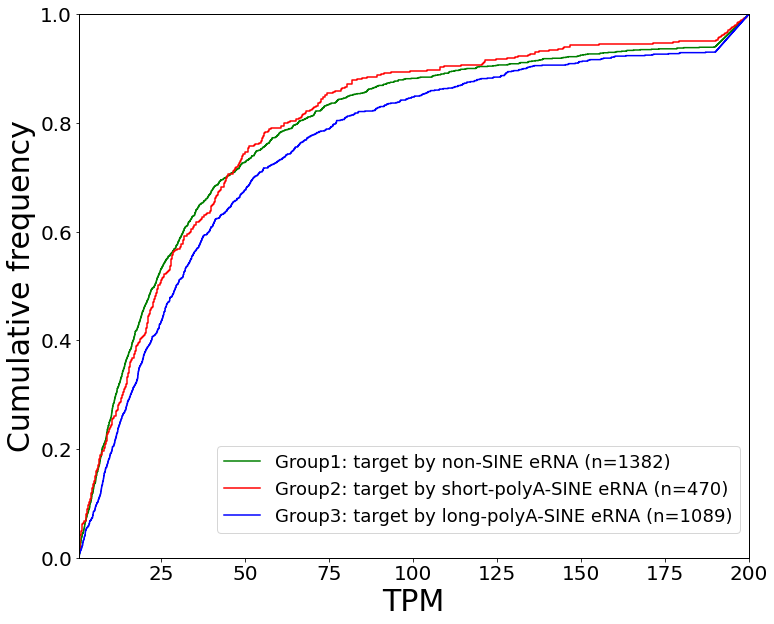

In [528]:
# Plot
fig, ax = plt.subplots(figsize=(12, 10))
plt.rc('axes', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('TPM', fontsize=30)
ax.set_ylabel('Cumulative frequency', fontsize=30)

max_num = 200
begin_ratio = 0.05

# dealLargerTPM_non_eRNA_target_gene_expression = dealLarger200TPM(non_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
# sns.ecdfplot(data=dealLargerTPM_non_eRNA_target_gene_expression, color='black', ax=ax)
dealLargerTPM_nonAlu_eRNA_target_gene_expression = dealLarger200TPM(nonAlu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_nonAlu_eRNA_target_gene_expression, color='green', ax=ax)
dealLargerTPM_shortPolyA_Alu_eRNA_target_gene_expression = dealLarger200TPM(shortPolyA_Alu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_shortPolyA_Alu_eRNA_target_gene_expression, color='red', ax=ax)
dealLargerTPM_longPolyA_Alu_eRNA_target_gene_expression = dealLarger200TPM(longPolyA_Alu_eRNA_target_gene_expression_filter, max_num=max_num, begin_ratio=begin_ratio)
sns.ecdfplot(data=dealLargerTPM_longPolyA_Alu_eRNA_target_gene_expression, color='blue', ax=ax)

# fig.legend(
#     labels=[f'Group1: no target by eRNA (n={non_eRNA_target_gene_expression_filter.shape[0]})',
#             f'Group2: target by non-SINE eRNA (n={nonAlu_eRNA_target_gene_expression_filter.shape[0]})',
#             f'Group3: target by short-polyA-SINE eRNA (n={shortPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})',
#             f'Group4: target by long-polyA-SINE eRNA (n={longPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})', 
#            ],  
#     loc="right", fontsize=18, bbox_to_anchor=(0.9,0.22)
#     )

fig.legend(
    labels=[f'Group1: target by non-SINE eRNA (n={nonAlu_eRNA_target_gene_expression_filter.shape[0]})',
            f'Group2: target by short-polyA-SINE eRNA (n={shortPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})',
            f'Group3: target by long-polyA-SINE eRNA (n={longPolyA_Alu_eRNA_target_gene_expression_filter.shape[0]})', 
           ],  
    loc="right", fontsize=18, bbox_to_anchor=(0.9,0.22)
    )

ax.set_xlim(gene_filter_threshold, max_num)
# ax.set_xlim(10, max_num)
# ax.set_ylim(0.2, 1)
plt.savefig('geneExpression.svg', format='svg', dpi=300)

In [529]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, shortPolyA_Alu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, shortPolyA_Alu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=1.203532083506326, pvalue=0.11447671771066052)
MannwhitneyuResult(statistic=280380.5, pvalue=0.0013532852605497375)


In [530]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=0.881972803717315, pvalue=0.1889386843895216)
MannwhitneyuResult(statistic=835981.5, pvalue=1.0621067691489254e-06)


In [531]:
print(stats.ttest_ind(longPolyA_Alu_eRNA_target_gene_expression_filter, non_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(longPolyA_Alu_eRNA_target_gene_expression_filter, non_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=4.866200692369502, pvalue=5.786303913877701e-07)
MannwhitneyuResult(statistic=5513864.5, pvalue=4.005733807996478e-59)


In [532]:
print(stats.ttest_ind(shortPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))
print(stats.mannwhitneyu(shortPolyA_Alu_eRNA_target_gene_expression_filter, nonAlu_eRNA_target_gene_expression_filter, alternative='greater'))

Ttest_indResult(statistic=-0.7833231238953239, pvalue=0.7832311731391948)
MannwhitneyuResult(statistic=329717.5, pvalue=0.3106671548219069)


In [533]:
promoter_df['kind'] = promoter_df.apply(lambda x:'1' if x[3] in non_eRNA_target_gene_filter_set else '2' if  x[3] in nonAlu_eRNA_target_gene_filter_set else '4' if x[3] in longPolyA_Alu_eRNA_target_gene_filter_set else '3' if x[3] in shortPolyA_Alu_eRNA_target_gene_filter_set else '5', axis=1)
promoter_df = promoter_df.loc[promoter_df['kind']!='5']
atacBW = pyBigWig.open('ENCFF901GZH.bigWig')
def ifRetain(row):
    chr = row[0]
    start = row[1]
    end = row[2]
    atacScore = np.array(atacBW.stats(chr, start, end, type='mean', nBins=1))[0]
    return atacScore

In [534]:
promoter_df['atacScore'] = promoter_df.apply(ifRetain, axis=1)
a = promoter_df.loc[promoter_df['kind']=='3', 'atacScore']
b = promoter_df.loc[promoter_df['kind']=='4', 'atacScore']
c = promoter_df.loc[promoter_df['kind']=='2', 'atacScore']
# print(stats.mannwhitneyu(np.log(a), np.log(b), alternative='less'))
# stats.ttest_ind(np.log(a), np.log(b), alternative='less')

f_val, p_val = stats.f_oneway(a, b, c)
print("F-value:", f_val)
print("P-value:", p_val)

F-value: 2.5680241727034425
P-value: 0.07685904288219007


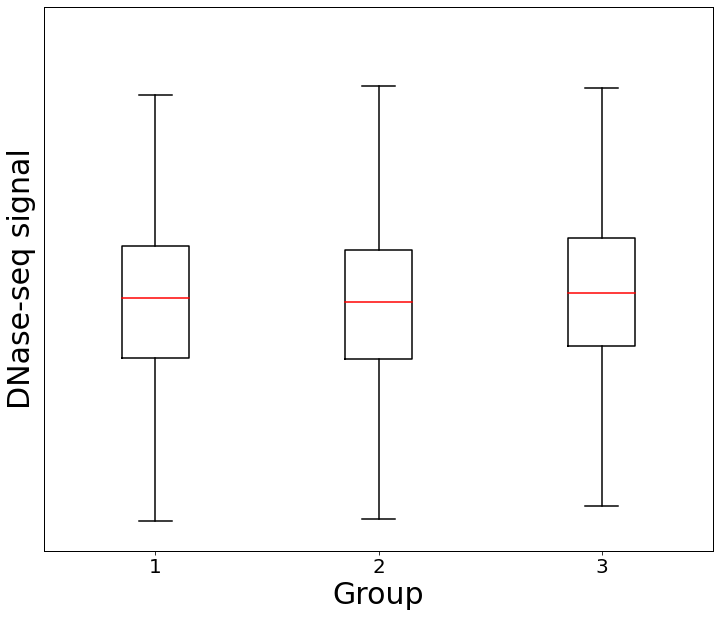

In [560]:
promoter_df = promoter_df.loc[promoter_df['kind'].isin({'2', '3', '4'})]
grouped_df = promoter_df.groupby('kind')

data = []
for name, group in grouped_df:
    data.append(np.log(group['atacScore']))
    
fig, ax = plt.subplots(figsize=(12, 10))
plt.rc('axes', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Group', fontsize=30)
ax.set_ylabel('DNase-seq signal', fontsize=30)
ax.set_ylim(-3.5, 2.0)
ax.set_yticks([])
plt.boxplot(data, labels=[int(x)-1 for x in grouped_df.groups.keys()], showfliers=False,
            medianprops=dict(color='red', linewidth=1.5), 
            boxprops={'linewidth': 1.5},
            whiskerprops={'linewidth': 1.5},
           capprops={'linewidth': 1.5})
plt.savefig('geneAccessibility.svg', format='svg', dpi=300)

[1, 2, 3]